# 01 - Exploratory Data Analysis (EDA)

This notebook performs the initial data loading, cleaning, KPI calculation (Loss Ratio = TotalClaims / TotalPremium), and a focused set of visualizations to explore risk and profitability. The original raw dataset is `data/MachineLearningRating_v3.txt` (pipe-separated).

Notes: the file is large (~500MB). The notebook reads a sample (or a few chunks) to avoid memory issues; update the read logic if you want to process the full dataset.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

In [5]:
# Locate the dataset (common locations)
candidates = [Path('../data') / 'MachineLearningRating_v3.txt', Path('../demo/SM/data') / 'insurance.csv', Path('../../SM') / 'data' / 'insurance.csv']
data_path = None
for c in candidates:
    if c.exists():
        data_path = c
        break
if data_path is None:
    # try a more general search in data and SM/data
    for p in list(Path('data').glob('*')) + list(Path('SM').glob('data/*')):
        if p.suffix.lower() in ('.txt', '.csv'):
            data_path = p
            break
print('Using data file:', data_path)

Using data file: ..\data\MachineLearningRating_v3.txt


In [6]:
# Read a limited number of rows/chunks to create a working sample and inspect columns
assert data_path is not None, 'Data file not found; place file under data/ or SM/data/'
# Decide separator based on file extension or first line
sep = '|' if data_path.suffix.lower() in ('.txt',) else ','
# For memory safety, read in chunks and concatenate a few chunks for preview
chunks = []
for i, chunk in enumerate(pd.read_csv(data_path, sep=sep, parse_dates=['TransactionMonth'] if 'TransactionMonth' in pd.read_csv(data_path, nrows=0).columns else [], chunksize=200000, low_memory=False)):
    print(f'Read chunk {i}, shape={chunk.shape}')
    chunks.append(chunk)
    if i >= 4:
        break
df = pd.concat(chunks, ignore_index=True)
print('Combined dataframe shape for preview:', df.shape)

Read chunk 0, shape=(200000, 52)
Read chunk 1, shape=(200000, 52)
Read chunk 1, shape=(200000, 52)
Read chunk 2, shape=(200000, 52)
Read chunk 2, shape=(200000, 52)
Read chunk 3, shape=(200000, 52)
Read chunk 3, shape=(200000, 52)
Read chunk 4, shape=(200000, 52)
Combined dataframe shape for preview: (1000000, 52)
Read chunk 4, shape=(200000, 52)
Combined dataframe shape for preview: (1000000, 52)


In [9]:
# Normalize column names (strip) and inspect columns
df.columns = [c.strip() for c in df.columns]
print('Columns (preview):')
print(df.columns.tolist())

# Convert TransactionMonth to datetime (if not already)
if 'TransactionMonth' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['TransactionMonth']):
    df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
    print('TransactionMonth conversion: ', df['TransactionMonth'].dtype)

# Ensure numeric types for financial columns
for col in ['TotalPremium', 'TotalClaims']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').str.strip(), errors='coerce')

# Print dtypes and a quick summary for the financials
print('Dtypes:')
print(df.dtypes)

print('Descriptive statistics for TotalPremium and TotalClaims:')
display(df[['TotalPremium', 'TotalClaims']].describe(percentiles=[0.25, 0.5, 0.75]))

print('Missing values per column (top 20):')
missing = df.isna().sum().sort_values(ascending=False)
print(missing.head(20))

# Compute LossRatio (guard division by zero)
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium'].replace({0: pd.NA})
print('Overall loss ratio (sum(TotalClaims) / sum(TotalPremium)) =', df['TotalClaims'].sum(skipna=True) / df['TotalPremium'].sum(skipna=True))

# Save processed preview for downstream cells
out_preview = Path('../data') / 'processed_sample_from_notebook_2.csv'
df.to_csv(out_preview, index=False)
print('Saved preview sample to', out_preview)

Columns (preview):
['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio']
Dtypes:
UnderwrittenCoverID                  int64
PolicyID                             int64
TransactionMonth            datetime64[ns]
IsVATRegistered              

,TotalPremium,TotalClaims
count,1000000.000000,1000000.000000
mean,61.902602,64.867546
std,230.287954,2384.191425
min,-782.576754,-12002.412281
25%,0.000000,0.000000
50%,2.178333,0.000000
75%,21.929825,0.000000
max,65282.603421,393092.105263


Missing values per column (top 20):
NumberOfVehiclesInFleet    1000000
CrossBorder                 999302
CustomValueEstimate         779548
WrittenOff                  641881
Converted                   641881
Rebuilt                     641881
LossRatio                   381634
NewVehicle                  153275
Bank                        145961
AccountType                  40232
Gender                        9536
MaritalStatus                 8241
VehicleIntroDate               552
VehicleType                    552
Cylinders                      552
make                           552
cubiccapacity                  552
kilowatts                      552
bodytype                       552
NumberOfDoors                  552
dtype: int64
NumberOfVehiclesInFleet    1000000
CrossBorder                 999302
CustomValueEstimate         779548
WrittenOff                  641881
Converted                   641881
Rebuilt                     641881
LossRatio                   381634
NewVeh

## Initial observations

The descriptive statistics above show the central tendency and spread of `TotalPremium` and `TotalClaims`. In many insurance datasets these columns are heavily right-skewed with a large number of zeros for claims. The `LossRatio` computed here is the simple aggregate ratio (sum of claims divided by sum of premiums) for the preview sample — use the full dataset for final business metrics.

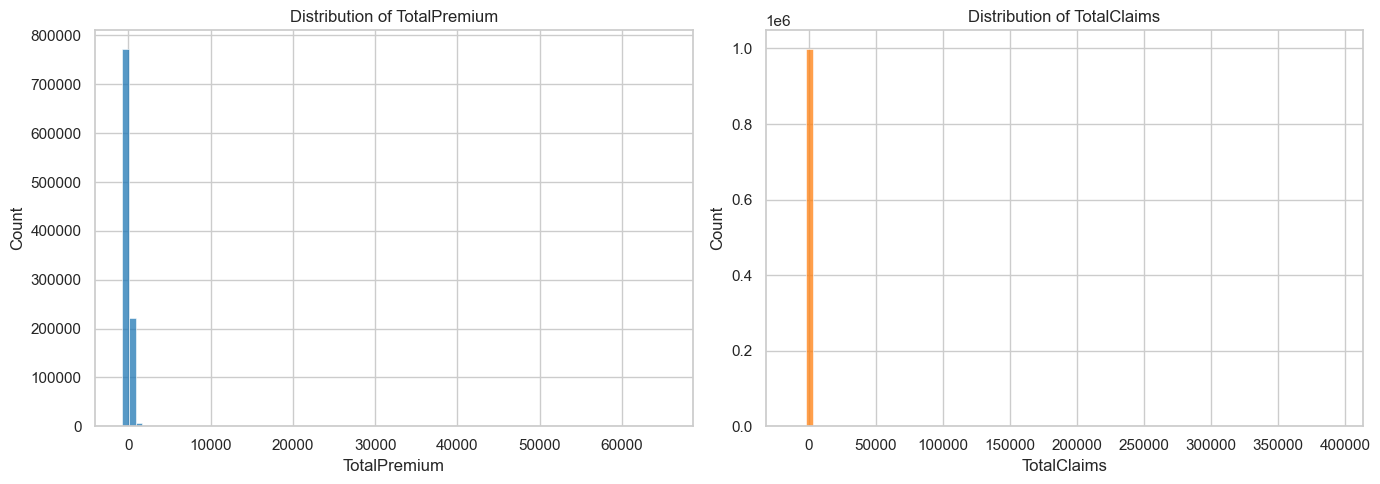

In [10]:
# --- Univariate plots: distributions for TotalPremium and TotalClaims ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
if 'TotalPremium' in df.columns:
    sns.histplot(df['TotalPremium'].dropna(), bins=80, ax=axes[0], color='tab:blue')
    axes[0].set_title('Distribution of TotalPremium')
    axes[0].set_xlabel('TotalPremium')
if 'TotalClaims' in df.columns:
    sns.histplot(df['TotalClaims'].dropna(), bins=80, ax=axes[1], color='tab:orange')
    axes[1].set_title('Distribution of TotalClaims')
    axes[1].set_xlabel('TotalClaims')
plt.tight_layout()
plt.show()

**Interpretation (univariate):**
- Look for heavy right skew and a strong mass at zero for `TotalClaims`.
- If premiums are also skewed, consider log-transformations for modeling (or use robust statistics).

C:\Users\nesre\AppData\Local\Temp\ipykernel_9152\578223401.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


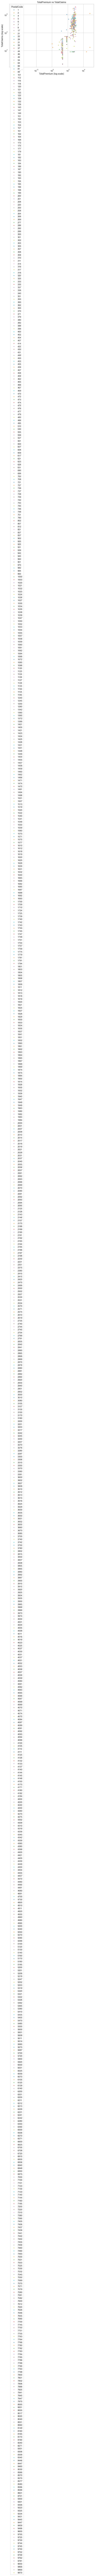

In [11]:
# --- Bivariate: TotalPremium vs TotalClaims ---
plt.figure(figsize=(8, 6))
hue_col = 'PostalCode' if 'PostalCode' in df.columns else 'Province' if 'Province' in df.columns else None
if hue_col:
    # sample for plotting to keep interactive speed
    sample = df.sample(frac=0.2, random_state=1) if len(df) > 50000 else df
    sns.scatterplot(data=sample, x='TotalPremium', y='TotalClaims', hue=hue_col, palette='tab10', alpha=0.6, s=20)
else:
    sns.scatterplot(data=df, x='TotalPremium', y='TotalClaims', color='tab:blue', alpha=0.4, s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('TotalPremium (log scale)')
plt.ylabel('TotalClaims (log scale)')
plt.title('TotalPremium vs TotalClaims')
plt.tight_layout()
plt.show()

**Interpretation (bivariate):**
- The log-log scatter helps reveal proportional relationships and separate outliers.
- Colouring by `Province` (or `PostalCode`) can reveal geographic clusters with different claim behaviours.

C:\Users\nesre\AppData\Local\Temp\ipykernel_9152\766858500.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grp, x='Province', y='LossRatio', palette='viridis')


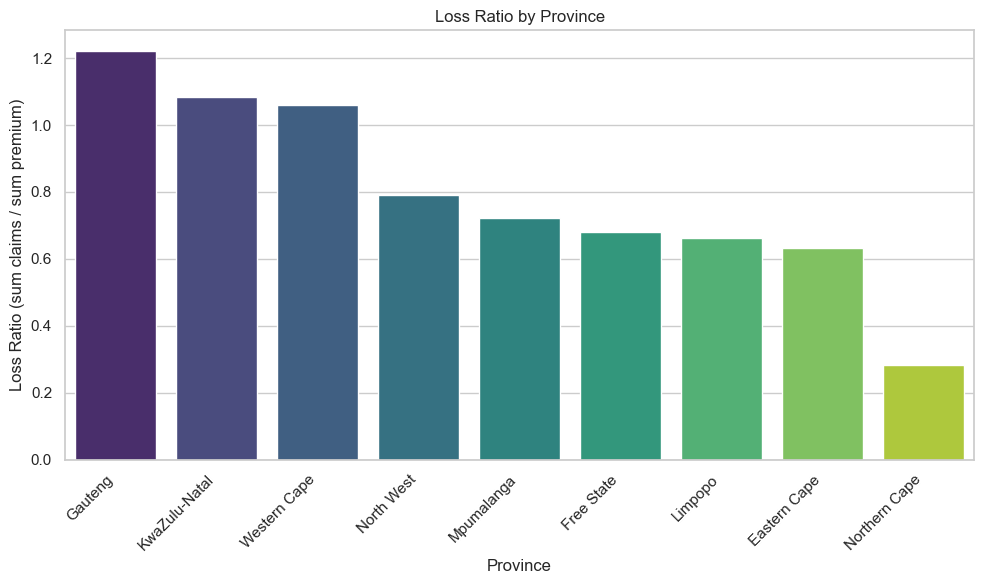

In [12]:
# --- Geographic trends: Loss Ratio by Province ---
if 'Province' in df.columns:
    grp = df.groupby('Province').agg({'TotalClaims': 'sum', 'TotalPremium': 'sum'})
    grp['LossRatio'] = grp['TotalClaims'] / grp['TotalPremium']
    grp = grp.sort_values('LossRatio', ascending=False).reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grp, x='Province', y='LossRatio', palette='viridis')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Loss Ratio (sum claims / sum premium)')
    plt.title('Loss Ratio by Province')
    plt.tight_layout()
    plt.show()
else:
    print('Column `Province` not found; skipping province-level plot')

**Interpretation (geographic):**
- Provinces with higher Loss Ratio are candidates for underwriting review or marketing filters.
- Check counts (`TotalPremium` sum and policy counts) to avoid over-interpreting ratios from very small samples.

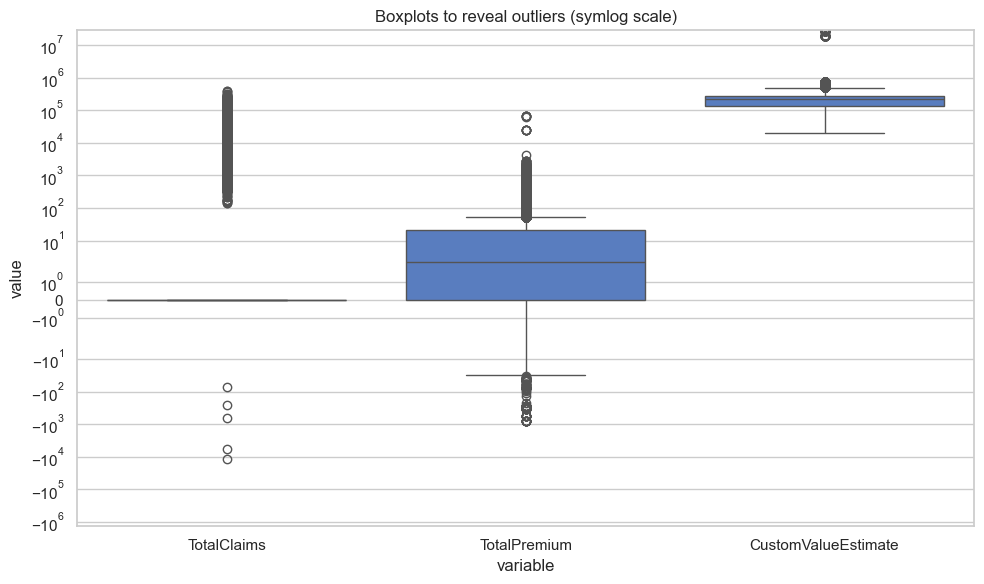

In [13]:
# --- Outlier detection: boxplots ---
cols = [c for c in ['TotalClaims', 'TotalPremium', 'CustomValueEstimate'] if c in df.columns]
if cols:
    long = df[cols].melt(var_name='variable', value_name='value')
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='variable', y='value', data=long)
    plt.yscale('symlog')
    plt.title('Boxplots to reveal outliers (symlog scale)')
    plt.tight_layout()
    plt.show()
else:
    print('No suitable numeric columns found for outlier boxplots')

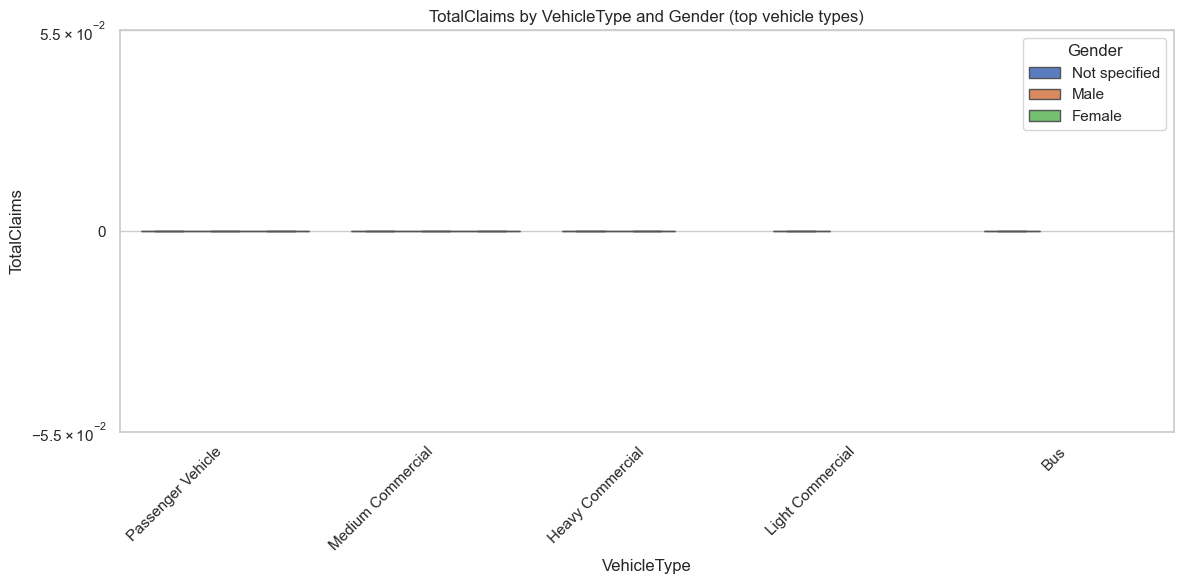

In [14]:
# --- Vehicle insights: TotalClaims by VehicleType and Gender ---
if set(['VehicleType', 'Gender', 'TotalClaims']).issubset(df.columns):
    plt.figure(figsize=(12, 6))
    # limit vehicle types to top N for readability
    top_vehicle_types = df['VehicleType'].value_counts().nlargest(8).index.tolist()
    df_v = df[df['VehicleType'].isin(top_vehicle_types)]
    sns.boxplot(x='VehicleType', y='TotalClaims', hue='Gender', data=df_v, showfliers=False)
    plt.yscale('symlog')
    plt.xticks(rotation=45, ha='right')
    plt.title('TotalClaims by VehicleType and Gender (top vehicle types)')
    plt.tight_layout()
    plt.show()
else:
    print('Missing one of VehicleType, Gender, or TotalClaims; cannot create vehicle/gender plot')